In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

from sklearn.metrics import (accuracy_score, classification_report, 
                           roc_auc_score, confusion_matrix, RocCurveDisplay)

In [3]:
df = pd.read_excel('../Data/Processed/processed_info.xlsx')

# Сразу удалим CC50 и SI, так как они рассчитываются друг через друга.
df.drop(['CC50, mM', 'SI'], axis=1, inplace=True)

## Бинаризация меток класса

In [4]:
median_ic50 = df['IC50, mM'].median()
df['target'] = df['IC50, mM'].apply(lambda x: 1 if x > median_ic50 else 0)
df.drop(['IC50, mM'], axis=1, inplace=True)

## Интерпретация ROC-AUC (Area Under the Receiver Operating Characteristic Curve)

**ROC-кривая** строится в координатах:
- **По оси X**: False Positive Rate (FPR) = `FP / (FP + TN)`
- **По оси Y**: True Positive Rate (TPR, Recall) = `TP / (TP + FN)`

### Значения AUC и их интерпретация

| **AUC**       | **Интерпретация**                                                                 |
|---------------|-----------------------------------------------------------------------------------|
| 0.90 - 1.00   | Отличное качество модели                                                          |
| 0.80 - 0.90   | Хорошее качество                                                                  |
| 0.70 - 0.80   | Приемлемое качество                                                               |
| 0.60 - 0.70   | Плохое качество (модель лишь немного лучше случайного угадывания)                 |
| 0.50 - 0.60   | Модель не лучше случайного предсказания                                           |
| < 0.50        | Модель работает хуже случайного угадывания (возможно, классы предсказываются наоборот) |

### Когда ROC-AUC может вводить в заблуждение?
1. **Сильный дисбаланс классов**  
   Если отрицательных примеров в 100 раз больше, высокий AUC может достигаться за счёт правильного предсказания только отрицательного класса.  
   *Решение*: Дополнительно смотреть Precision-Recall AUC.

2. **Разные costs ошибок**  
   Если ложные положительные дороже ложных отрицательных, нужно выбирать другую точку на кривой (не максимизировать AUC).  
   *Решение*: Использовать `roc_curve()` для выбора оптимального порога.

## Логистическая регрессия

Accuracy: 0.6965174129353234

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.69      0.69        97
           1       0.71      0.70      0.71       104

    accuracy                           0.70       201
   macro avg       0.70      0.70      0.70       201
weighted avg       0.70      0.70      0.70       201

ROC-AUC: 0.762539651070579


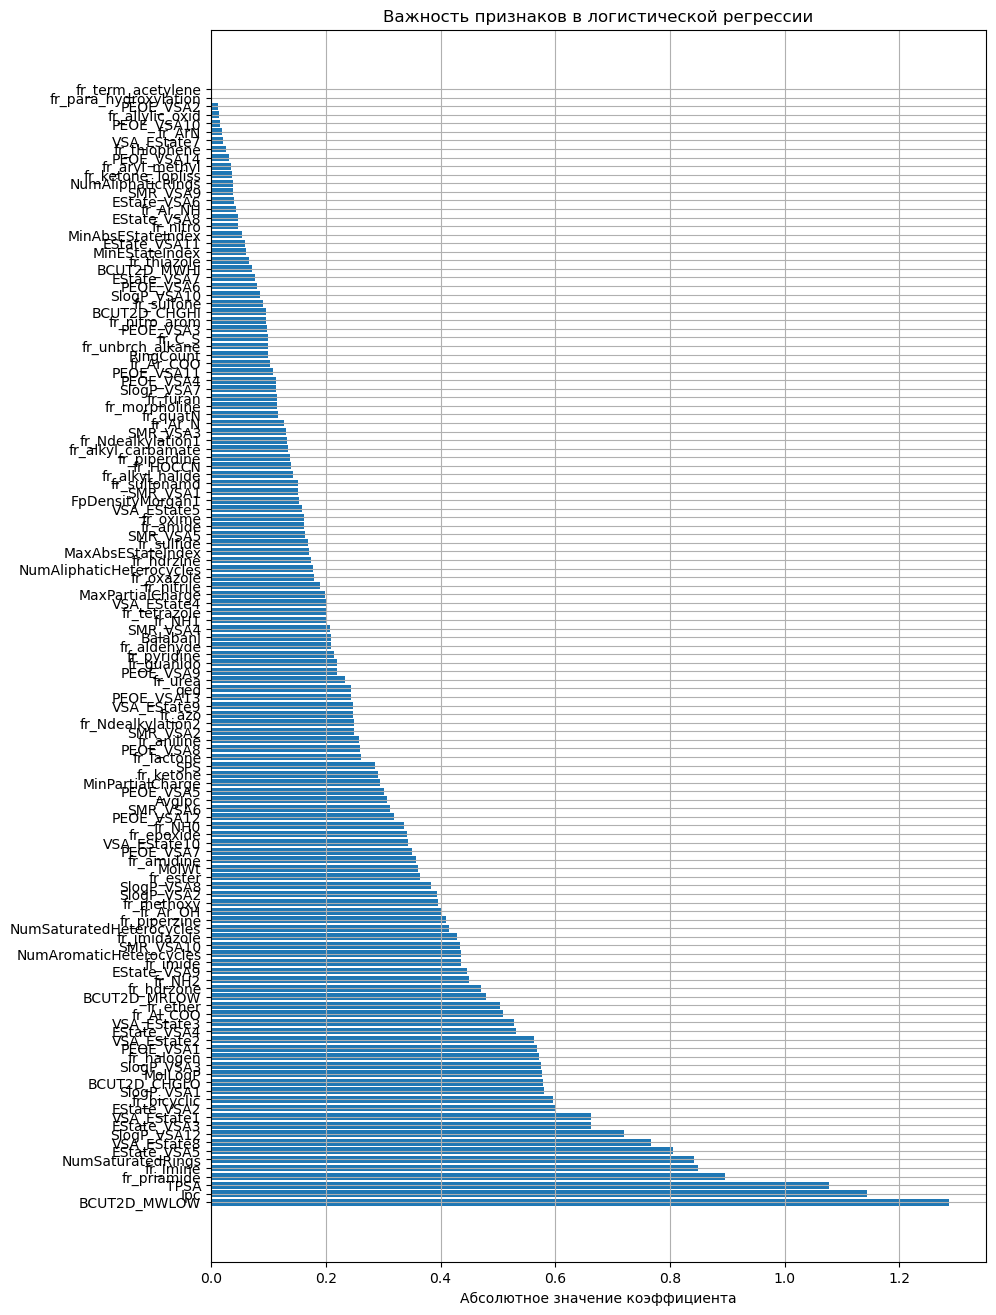

In [13]:
X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # Вероятности для ROC-AUC

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

# Важность признаков (коэффициенты)
if hasattr(model, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_[0],
        'Abs_Coefficient': np.abs(model.coef_[0])  # Абсолютные значения для сравнения
    }).sort_values('Abs_Coefficient', ascending=False)

# Визуализация
plt.figure(figsize=(10, 16))
plt.barh(feature_importance['Feature'], feature_importance['Abs_Coefficient'])
plt.title('Важность признаков в логистической регрессии')
plt.xlabel('Абсолютное значение коэффициента')
plt.grid(True)
plt.show()

## Дерево решений

Лучшие параметры: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5}

Accuracy: 0.6865671641791045

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.75      0.70        97
           1       0.73      0.62      0.67       104

    accuracy                           0.69       201
   macro avg       0.69      0.69      0.69       201
weighted avg       0.69      0.69      0.69       201

ROC-AUC: 0.6849722442505948

Confusion Matrix:
 [[73 24]
 [39 65]]


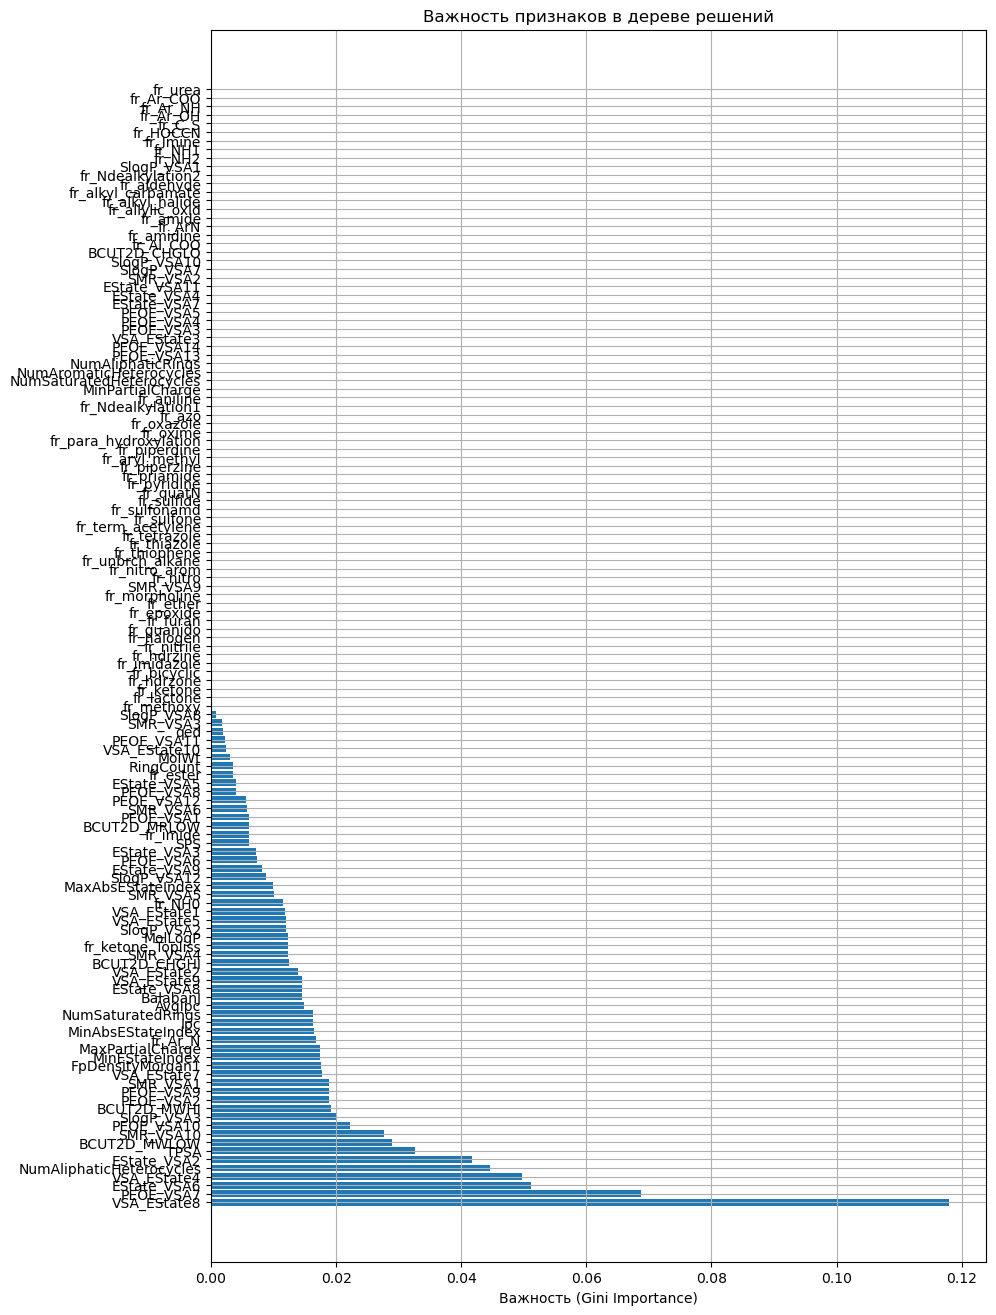


Дерево слишком глубокое для визуализации (глубина = 10).


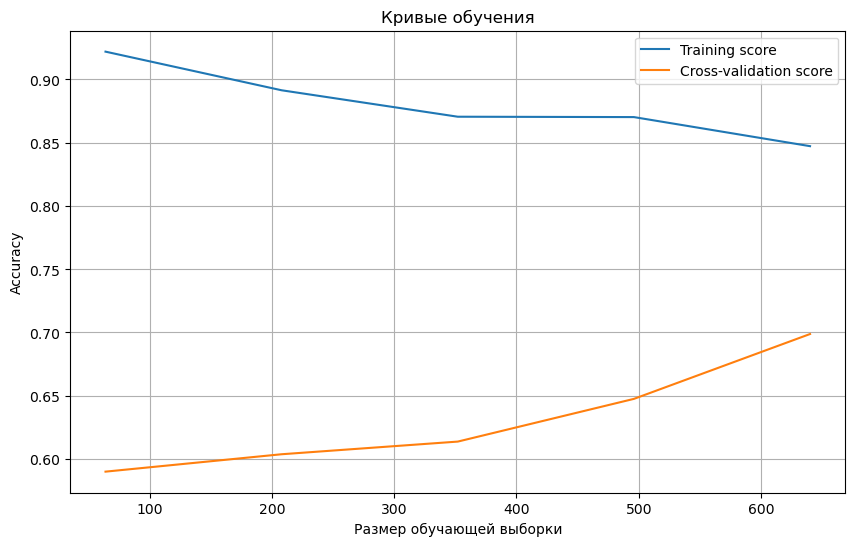

In [22]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Подбор гиперпараметров через GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 10, None],           # Глубина дерева
    'min_samples_split': [2, 5, 10],            # Минимальное число образцов для разделения узла
    'min_samples_leaf': [1, 2, 4],              # Минимальное число образцов в листе
    'criterion': ['gini', 'entropy'],           # Критерий разделения
    'max_features': ['sqrt', 'log2', None]      # Количество признаков для поиска лучшего разделения
}

model = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,                # Количество фолдов кросс-валидации
    scoring='accuracy',  # Метрика для оптимизации
    n_jobs=-1            # Использовать все ядра процессора
)
model.fit(X_train_scaled, y_train)

print("Лучшие параметры:", model.best_params_)
best_model = model.best_estimator_

y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 16))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Важность признаков в дереве решений')
plt.xlabel('Важность (Gini Importance)')
plt.grid(True)
plt.show()

# Визуализация лучшего дерева (для max_depth <= 3)
if best_model.get_depth() <= 3:
    plt.figure(figsize=(20, 10))
    plot_tree(
        best_model,
        feature_names=X.columns,
        class_names=['IC50 ≤ медианы', 'IC50 > медианы'],
        filled=True,
        rounded=True
    )
    plt.title("Оптимальное дерево решений")
    plt.show()
else:
    print("\nДерево слишком глубокое для визуализации (глубина = {}).".format(best_model.get_depth()))

# Кривые обучения
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_scaled, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Кривые обучения')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Случайный лес

Accuracy: 0.736318407960199

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.76      0.74        97
           1       0.76      0.71      0.74       104

    accuracy                           0.74       201
   macro avg       0.74      0.74      0.74       201
weighted avg       0.74      0.74      0.74       201

ROC-AUC: 0.8000594766058684

Confusion Matrix:
 [[74 23]
 [30 74]]

Feature Importance:
                Feature  Importance
63         VSA_EState8    0.036921
13        BCUT2D_MRLOW    0.032241
10        BCUT2D_MWLOW    0.031088
60         VSA_EState4    0.026537
36            SMR_VSA5    0.023563
..                 ...         ...
74           fr_Ar_COO    0.000000
125  fr_term_acetylene    0.000000
126       fr_tetrazole    0.000000
100         fr_guanido    0.000000
130            fr_urea    0.000000

[131 rows x 2 columns]


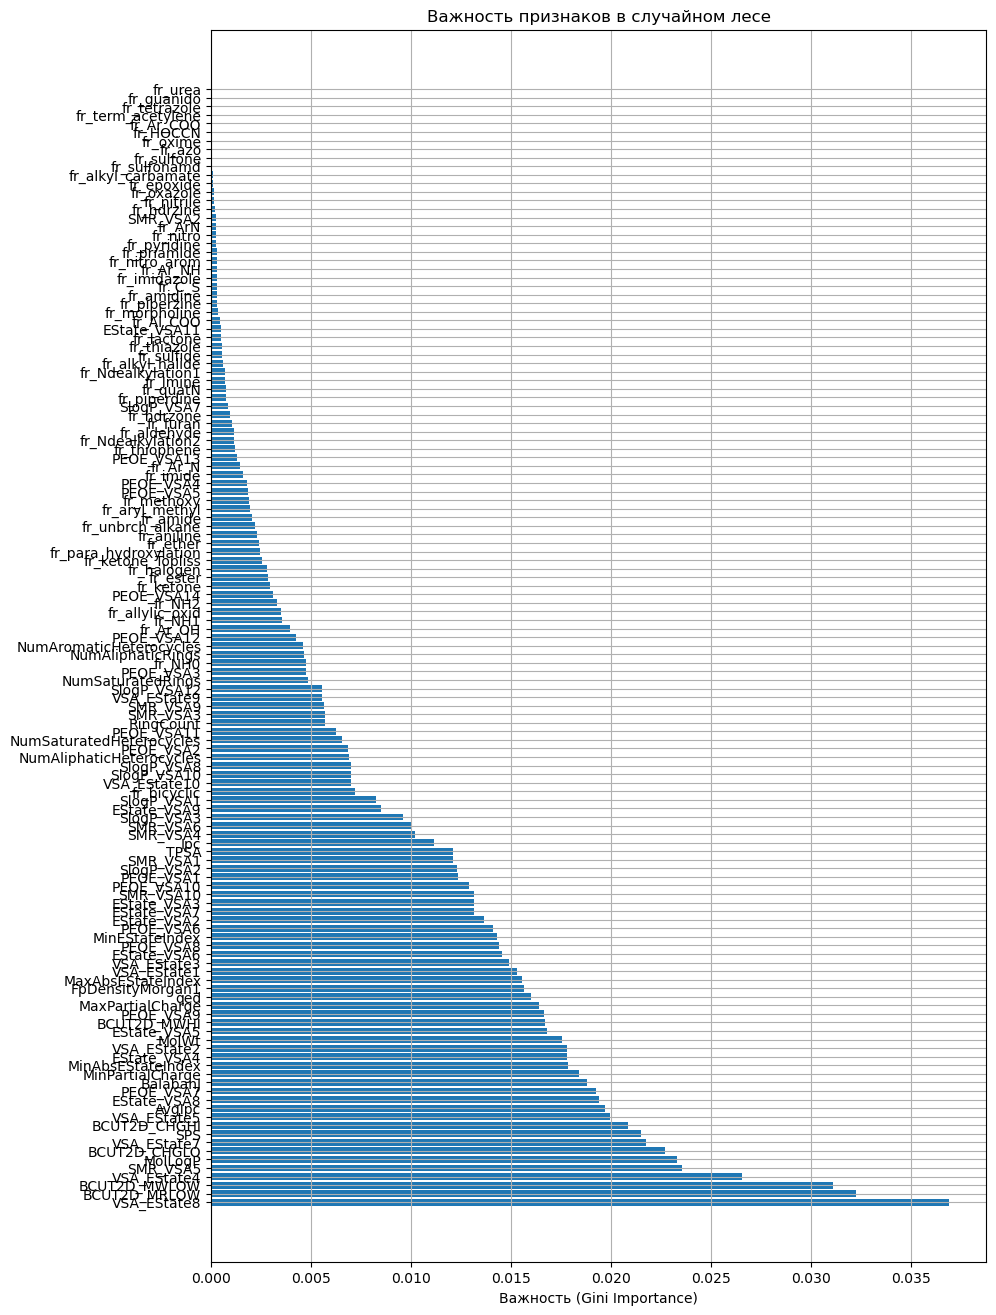

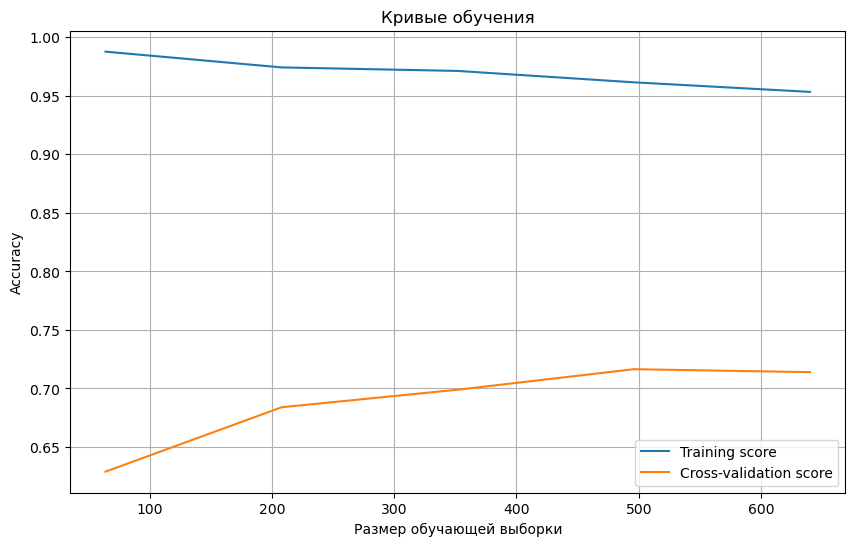

In [24]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(
    n_estimators=100,      # Количество деревьев
    max_depth=None,        # Глубина деревьев (None - до полного разделения)
    min_samples_split=2,   # Минимальное число образцов для разделения узла
    random_state=42,
    n_jobs=-1              # Использовать все ядра процессора
)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # Вероятности класса 1

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# Важность признаков
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:\n", feature_importance)

plt.figure(figsize=(10, 16))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Важность признаков в случайном лесе')
plt.xlabel('Важность (Gini Importance)')
plt.grid(True)
plt.show()

# Кривые обучения
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_scaled, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Кривые обучения')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Метод ближайших соседей

Лучшие параметры: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}

Accuracy: 0.6915422885572139

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.73      0.70        97
           1       0.72      0.65      0.69       104

    accuracy                           0.69       201
   macro avg       0.69      0.69      0.69       201
weighted avg       0.69      0.69      0.69       201

ROC-AUC: 0.7331482950039652

Confusion Matrix:
 [[71 26]
 [36 68]]


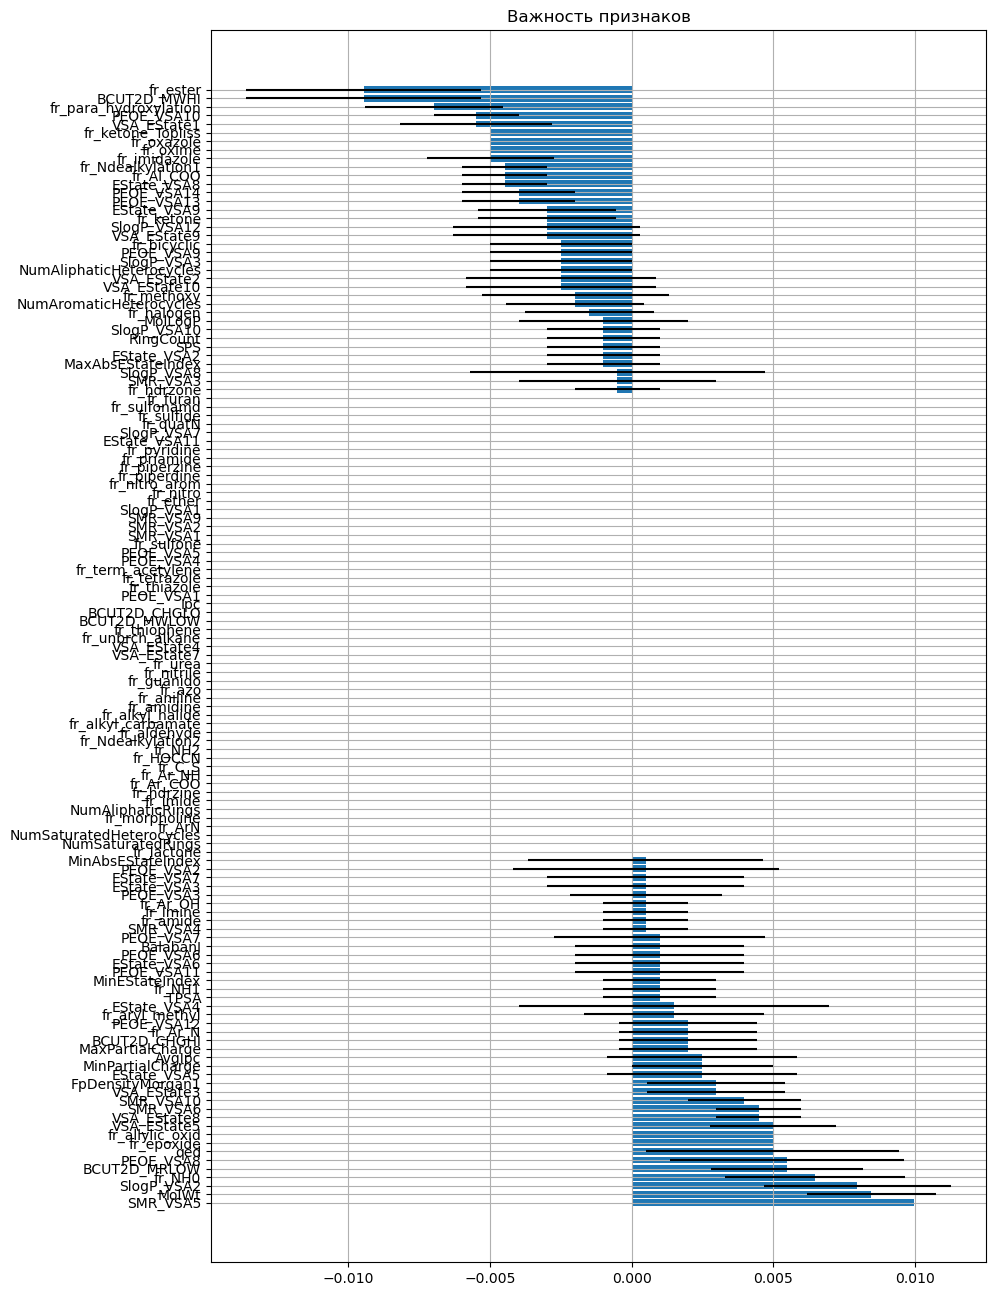

In [29]:
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'n_neighbors': range(3, 15),                # Число соседей (от 3 до 14)
    'weights': ['uniform', 'distance'],         # Веса: одинаковые или обратно пропорциональные расстоянию
    'p': [1, 2]                                 # Метрика (1 - манхэттенское, 2 - евклидово расстояние)
}

model = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,               # Кросс-валидация на 5 фолдов
    scoring='accuracy',
    n_jobs=-1
)
model.fit(X_train_scaled, y_train)

print("Лучшие параметры:", model.best_params_)
best_knn = model.best_estimator_

y_pred = best_knn.predict(X_test_scaled)
y_pred_proba = best_knn.predict_proba(X_test_scaled)[:, 1]

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# Анализ важности признаков
result = permutation_importance(
    best_knn, X_test_scaled, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values('Importance', ascending=False)


plt.figure(figsize=(10, 16))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], xerr=feature_importance['Std'])
plt.title('Важность признаков')
plt.grid(True)
plt.show()

## **Сравнительная таблица результатов**

| Модель                  | Точность | ROC-AUC | Лучшие параметры                                                                 |
|-------------------------|---------------------|---------|---------------------------------------------------------------------------------|
| Логистическая регрессия | 0.70                | 0.76    | -                                                                               |
| Дерево решений          | 0.69                | 0.68    | `max_depth=10`, `min_samples_split=5`, `criterion='gini'`, `max_features='sqrt'`|
| Случайный лес           | 0.74                | 0.80    | -                                                                               |
| k-Ближайшие соседи      | 0.69                | 0.73    | `n_neighbors=3`, `p=1` (манхэттенское расстояние), `weights='uniform'`          |


### **Логистическая регрессия**
- **Плюсы**:
  - Простота интерпретации (можно анализировать коэффициенты признаков).
- **Минусы**:
  - Предполагает линейную зависимость между признаками и целевой переменной.


### **Дерево решений**
- **Плюсы**:
  - Интерпретируемость (можно визуализировать дерево).
  - Автоматический выбор важных признаков.
- **Минусы**:
  - Склонность к переобучению (даже с подобранными параметрами ROC-AUC = 0.68 — самый низкий среди всех моделей).
  - Нестабильность (малые изменения в данных могут сильно изменить структуру дерева).

### **Случайный лес**
- **Плюсы**:
  - Лучшая точность (0.74) и ROC-AUC (0.80).
  - Устойчивость к переобучению (по сравнению с одним деревом).
  - Работает с нелинейными зависимостями.
- **Минусы**:
  - Менее интерпретируем, чем логистическая регрессия или дерево.
  - Требует больше вычислительных ресурсов.


### **k-Ближайшие соседи (k-NN)**
- **Плюсы**:
  - Простота реализации.
  - Хороший ROC-AUC (0.73) при небольшой точности (0.69).
- **Минусы**:
  - Чувствителен к масштабированию данных.
  - Медленный на больших данных (из-за вычисления расстояний).


## **Рекомендации**
1. **Фичингениринг**:
   - Добавить новые признаки (например, молекулярные дескрипторы, если IC50 — это активность соединений).
   - Попробовать PCA или t-SNE для уменьшения размерности.

2. **Оптимизация гиперпараметров**:
   - Для случайного леса: подобрать `n_estimators`, `max_features`, `min_samples_leaf`.
   - Для k-NN: попробовать `weights='distance'` и другие метрики расстояния.

3. **Работа с дисбалансом классов**:
   - Если классы несбалансированы (например, IC50 > медианы встречается редко), использовать:
     - `class_weight='balanced'` в логистической регрессии и случайном лесе.
     - Метрики Precision-Recall вместо ROC-AUC.

4. **Ансамбли моделей**:
   - Объединить несколько моделей (например, логистическую регрессию + случайный лес) через голосование или стэкинг.


Таким образом, проведено сравнение моделей, сделаны выводы и даны рекомендации.